In [1]:
import os
import re
from pydub import AudioSegment
import pandas as pd
import pylab as plt
import random
from tqdm import tqdm
from datasets import Dataset, DatasetDict


base_dir_cmu = '/mnt/data/Speech Dataset/CMUSynth/CMU-synth/'
clips_cmu = f'{base_dir_cmu}clips/'

c_df = pd.read_csv(f'{base_dir_cmu}train.tsv', header=None, sep='\t', names=['audio', 'text'])

print(c_df.shape)

def random_cutter(dur):
    if random.random() < 0.15:
        return dur > 30 * (random.random()*0.95+0.05)
    else:
        return dur > 30
    
c_df.head()

(63768, 2)


,audio,text
0,50001,ਪਲੇਟ ਵਿਚ ਲੋੜ ਤੋਂ ਘੱਟ ਭੋਜਨ ਪਾਓ ਭੁੱਖ ਬਾਕੀ ਰੱਖ ਕੇ...
1,50002,ਘਰ ਦੇ ਮੋਢੀ ਨੂੰ ਪਰ੍ਹਿਆਂ ਪਚੈਤਾਂ ਵਿੱਚ ਬੁਲਾ ਕੇ ਖੱਜ...
2,50003,ਮਾੜੀ ਗਲ ਇਹ ਕਿ ਇਨ੍ਹਾਂ ਦੀ ਬੋਲੀ ਸਮਝਣੀ ਆਮ ਇਨਸਾਨ ਦੇ...
3,50004,ਫਸਟ ਆਉਣ ਦਾ ਇਕ ਕਾਰਨ ਇਹ ਵੀ ਸੀ ਕਿ ਕੁਝ ਸੁਟਾਵੇ ਕੈਂਪ...
4,50005,ਉਹਦੇ ਪੈਰੀਂ ਦੌੜਨ ਵਾਲੇ ਬੂਟ ਸਨ ਤੇ ਉਹ ਕਿਸੇ ਮਸਤੀ ਚ ...


In [2]:
c_df['audio'] = c_df['audio'].apply(lambda x: str(x).strip() + '.wav')
c_df['audio'] = clips_cmu + c_df['audio']
print(f'{c_df.head(1)['audio'].to_json()}')


def chunk_merger(args):
    """
    Adapted chunk_merger to use with DataFrame and duration, optimized for multiprocessing.
    """
    df, expanded_clips_path = args

    result = []
    expanding_row = None
    expanding_audio = None

    for index, row in tqdm(df.iterrows(), total=len(df), desc='Processing segments'):
        audio_path = os.path.join(row["audio"])
        audio = AudioSegment.from_file(audio_path)
        duration = audio.duration_seconds

        text = row['text'].strip()

        if expanding_row is None:
            expanding_row = row
            expanding_audio = audio
        elif random_cutter(expanding_audio.duration_seconds + duration):
            output_file_path = os.path.join(expanded_clips_path, f'{os.path.basename(audio_path)}.wav')
            expanding_audio.export(output_file_path, format='wav')
            expanding_row['duration'] = expanding_audio.duration_seconds
            expanding_row['audio'] = output_file_path
            result.append(expanding_row)
            expanding_row = row
            expanding_audio = audio
        else:
            expanding_row['text'] += ' ' + text
            expanding_audio += audio

    if expanding_row is not None and expanding_audio is not None:
        output_file_path = os.path.join(expanded_clips_path, f'{os.path.basename(expanding_row["audio"])}.wav')
        expanding_audio.export(output_file_path, format='wav')
        expanding_row['duration'] = expanding_audio.duration_seconds
        expanding_row['audio'] = output_file_path
        result.append(expanding_row)

    return result

expanded_path_cmu = f'{base_dir_cmu}expanded_clips/'

os.makedirs(expanded_path_cmu, exist_ok=True)

result_cmu = chunk_merger((c_df, expanded_path_cmu))
df = pd.DataFrame(result_cmu)

df.head(2)

{"0":"\/mnt\/data\/Speech Dataset\/CMUSynth\/CMU-synth\/clips\/50001.wav"}


Processing segments: 100%|██████████| 63768/63768 [09:04<00:00, 117.13it/s] 


,audio,text,duration
0,/mnt/data/Speech Dataset/CMUSynth/CMU-synth/ex...,ਪਲੇਟ ਵਿਚ ਲੋੜ ਤੋਂ ਘੱਟ ਭੋਜਨ ਪਾਓ ਭੁੱਖ ਬਾਕੀ ਰੱਖ ਕੇ...,22.010
5,/mnt/data/Speech Dataset/CMUSynth/CMU-synth/ex...,ਸ੍ਰੀ ਮੁਸ਼ੱਰਫ ਅੱਜ ਕਲ੍ਹ ਜਲਾਵਤਨ ਹਨ ਅਤੇ ਦੇਸ਼ ਵਾਪਸੀ ਲ...,4.505


(array([ 411.,  670.,  455.,  536.,  805.,  882.,  730., 3154., 5439.,
        5097.]),
 array([ 4.12 ,  6.708,  9.296, 11.884, 14.472, 17.06 , 19.648, 22.236,
        24.824, 27.412, 30.   ]),
 <BarContainer object of 10 artists>)

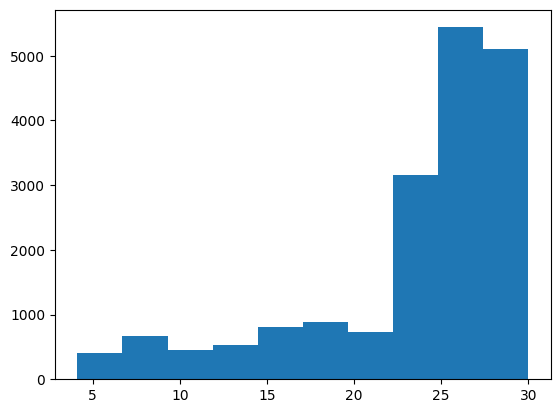

In [3]:
import pylab as plt
plt.hist(df['duration'])

In [7]:
# add two new columns i.e speaker_id and gender
# init with None
df = df.assign(speaker_id=None)
df = df.assign(gender=None)

cmu_test = pd.read_csv(f'{base_dir_cmu}test.tsv', header=None, sep='\t', names=['audio', 'text'])
cmu_valid = pd.read_csv(f'{base_dir_cmu}dev.tsv', header=None, sep='\t', names=['audio', 'text'])

cmu_test['audio'] = cmu_test['audio'].apply(lambda x: str(x).strip() + '.wav')
cmu_valid['audio'] = cmu_valid['audio'].apply(lambda x: str(x).strip() + '.wav')
cmu_test['audio'] = clips_cmu + cmu_test['audio']
cmu_valid['audio'] = clips_cmu + cmu_valid['audio']

print(cmu_test.head(2)['audio'].to_list())

cmu_test = cmu_test.reset_index(drop=True)
cmu_valid = cmu_valid.reset_index(drop=True)

cmu_test['duration'] = cmu_test['audio'].apply(lambda x: AudioSegment.from_file(x).duration_seconds)
cmu_valid['duration'] = cmu_valid['audio'].apply(lambda x: AudioSegment.from_file(x).duration_seconds)

cmu_test = cmu_test.assign(speaker_id=None)
cmu_test = cmu_test.assign(gender=None)
cmu_valid = cmu_valid.assign(speaker_id=None)
cmu_valid = cmu_valid.assign(gender=None)

from datasets import DatasetDict, Dataset, Audio


ds_cmu = DatasetDict({'train': Dataset.from_pandas(df.reset_index(drop=True)), 'test': Dataset.from_pandas(cmu_test), 'valid': Dataset.from_pandas(cmu_valid)})


ds_cmu = ds_cmu.cast_column('audio', Audio(sampling_rate = 16000))
ds_cmu = ds_cmu.cast_column('audio', Audio(sampling_rate = 16000))


print(ds_cmu)
print(ds_cmu['train'][0])
print(ds_cmu['valid'][0])


['/mnt/data/Speech Dataset/CMUSynth/CMU-synth/clips/121742.wav', '/mnt/data/Speech Dataset/CMUSynth/CMU-synth/clips/121743.wav']
DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'duration', 'speaker_id', 'gender'],
        num_rows: 18179
    })
    test: Dataset({
        features: ['audio', 'text', 'duration', 'speaker_id', 'gender'],
        num_rows: 7971
    })
    valid: Dataset({
        features: ['audio', 'text', 'duration', 'speaker_id', 'gender'],
        num_rows: 7971
    })
})
{'audio': {'path': '/mnt/data/Speech Dataset/CMUSynth/CMU-synth/expanded_clips/50006.wav', 'array': array([ 0.        ,  0.        ,  0.        , ...,  0.00067139,
        0.00061035, -0.00088501]), 'sampling_rate': 16000}, 'text': 'ਪਲੇਟ ਵਿਚ ਲੋੜ ਤੋਂ ਘੱਟ ਭੋਜਨ ਪਾਓ ਭੁੱਖ ਬਾਕੀ ਰੱਖ ਕੇ ਹੀ ਭੋਜਨ ਲਵੋ ਘਰ ਦੇ ਮੋਢੀ ਨੂੰ ਪਰ੍ਹਿਆਂ ਪਚੈਤਾਂ ਵਿੱਚ ਬੁਲਾ ਕੇ ਖੱਜਲ ਕੀਤਾ ਜਾਂਦਾ ਹੈ ਮਾੜੀ ਗਲ ਇਹ ਕਿ ਇਨ੍ਹਾਂ ਦੀ ਬੋਲੀ ਸਮਝਣੀ ਆਮ ਇਨਸਾਨ ਦੇ ਵਸ ਨਹੀਂ ਹੁੰਦੀ ਫਸਟ ਆਉਣ ਦਾ ਇਕ ਕਾਰਨ ਇਹ ਵੀ ਸੀ ਕਿ ਕੁਝ ਸੁਟਾਵੇ ਕੈਂਪ ਵਿਚ ਨਹੀਂ ਸੀ ਆਏ ਉਹਦੇ 

In [8]:
ds_cmu.save_to_disk('/mnt/data/Speech Dataset/processed_datasets/CMU_Synth_ASR/', num_proc=24)

Saving the dataset (0/28 shards):   0%|          | 0/18179 [00:00<?, ? examples/s]

Saving the dataset (0/24 shards):   0%|          | 0/7971 [00:00<?, ? examples/s]

Saving the dataset (0/24 shards):   0%|          | 0/7971 [00:00<?, ? examples/s]